# 阶段2：HMM建模（生成Y标签）

本notebook完成以下任务：
1. 加载训练集数据和Top-K特征
2. 训练粗粒度HMM（3-4个状态）
3. 训练细粒度HMM（低通信状态细分）
4. 对所有数据集预测状态
5. 将状态映射为Y标签（二分类或多分类）
6. 分析HMM状态分布和转移
7. 保存HMM模型和Y标签


In [1]:
# 导入必要的库和配置
%run 00_config_and_setup.ipynb

import config
from utils.data_utils import load_intermediate, save_intermediate
from utils.hmm_utils import train_coarse_hmm, train_fine_hmm, predict_hmm_states, map_states_to_labels

print("准备开始HMM建模...")


✓ 所有库导入完成
✓ 配置文件加载完成
项目根目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025
输出目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs
中间结果目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
✓ 显示选项设置完成
✓ 输出目录创建完成
  - 中间结果: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
  - 模型文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models
  - 报告文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports
  - 可视化: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations
✓ 随机种子设置为: 42
✓ 可视化样式设置完成: seaborn-v0_8
✓ 工具函数导入完成
准备开始HMM建模...


## 1. 加载数据


In [2]:
# 加载训练集数据和Top-K特征
train_data = load_intermediate('train_data')
top_k_features = load_intermediate('top_k_features')

print(f"训练集形状: {train_data.shape}")
print(f"Top-K特征数量: {len(top_k_features)}")
print(f"Top-K特征列表: {top_k_features[:10]}...")  # 显示前10个


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\top_k_features.pkl
训练集形状: (67447, 117)
Top-K特征数量: 50
Top-K特征列表: ['dominance_ratio_std', 'bigram_entropy_mean', 'eigenvector_conversation', 'material_diversity_min', 'material_diversity_mean', 'participant_D_interactions', 'dominance_ratio_max', 'total_interactions', 'participant_B_interactions', 'fano_switch_std']...


## 2. 准备训练数据（按组组织）


In [3]:
# 提取训练集的特征（Top-K特征）
X_train_features = train_data[top_k_features].copy()

# 按组组织数据（每个组一个序列）
train_sequences = []
train_groups = sorted(train_data['group'].unique())

for group_id in train_groups:
    group_data = train_data[train_data['group'] == group_id].copy()
    group_data = group_data.sort_values('window_idx')
    X_group = group_data[top_k_features].values
    train_sequences.append(X_group)
    print(f"组{group_id}: {len(X_group)} 个窗口")

# 合并所有组的序列
X_train_combined = np.vstack(train_sequences)
print(f"\n总训练数据: {len(X_train_combined)} 个窗口, {X_train_combined.shape[1]} 个特征")


组1: 471 个窗口
组2: 579 个窗口
组3: 876 个窗口
组4: 769 个窗口
组5: 409 个窗口
组6: 2443 个窗口
组7: 61385 个窗口
组8: 515 个窗口

总训练数据: 67447 个窗口, 50 个特征


## 3. 训练粗粒度HMM


In [5]:
# 训练粗粒度HMM
print("开始训练粗粒度HMM...")
coarse_hmm = train_coarse_hmm(
    X_train_combined,
    n_states=config.HMM_CONFIG['coarse_n_states'],
    n_iter=config.HMM_CONFIG['n_iter'],
    covariance_type=config.HMM_CONFIG['covariance_type'],
    random_state=config.HMM_CONFIG['random_state']
)

print(f"✓ 粗粒度HMM训练完成")
print(f"状态数: {coarse_hmm.n_components}")
print(f"状态转移矩阵形状: {coarse_hmm.transmat_.shape}")
print(f"初始状态概率: {coarse_hmm.startprob_}")


开始训练粗粒度HMM...


Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


✓ 粗粒度HMM训练完成
状态数: 4
状态转移矩阵形状: (4, 4)
初始状态概率: [0. 0. 0. 1.]


## 4. 分析粗粒度状态


粗粒度状态分布:
  状态0: 61084 个窗口 (90.57%)
  状态1: 2388 个窗口 (3.54%)
  状态2: 1391 个窗口 (2.06%)
  状态3: 2584 个窗口 (3.83%)


C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\1353821464.py:17: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\1353821464.py:17: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\1353821464.py:17: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\1353821464.py:17: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\1353821464.py:17: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\1353821464.py:17: UserWarning: Glyph 31895 (\N{CJK UNIFIED IDEOGRAPH-7C97})

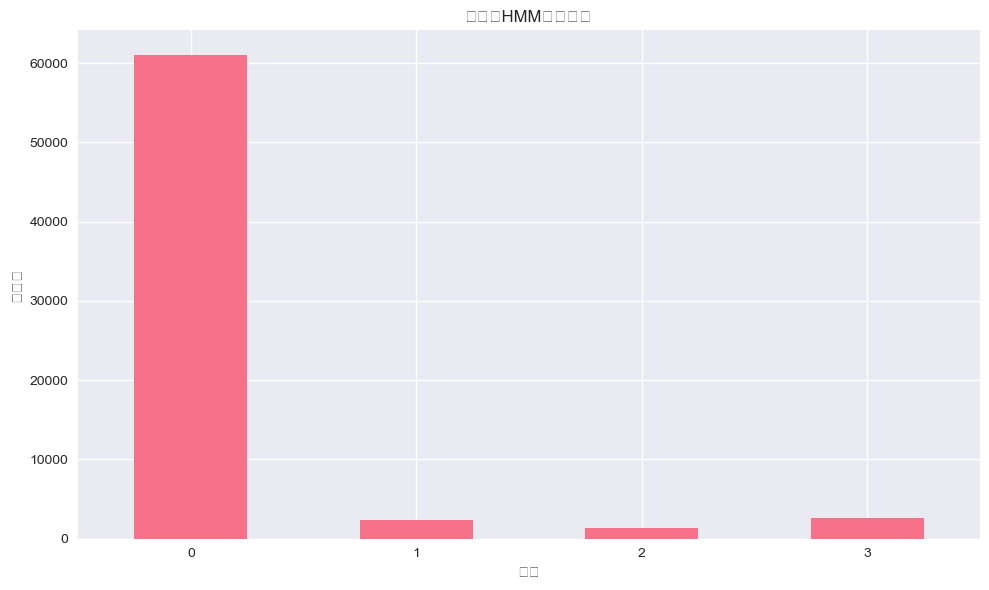

In [6]:
# 在训练集上预测状态
train_states = coarse_hmm.predict(X_train_combined)

# 分析状态分布
state_counts = pd.Series(train_states).value_counts().sort_index()
print("粗粒度状态分布:")
for state, count in state_counts.items():
    print(f"  状态{state}: {count} 个窗口 ({count/len(train_states)*100:.2f}%)")

# 可视化状态分布
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar')
plt.xlabel('状态')
plt.ylabel('窗口数')
plt.title('粗粒度HMM状态分布')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / 'hmm_coarse_state_distribution.png', dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()


## 5. 训练细粒度HMM（可选）


In [7]:
# 识别低通信状态（假设最后一个状态是低通信状态）
low_comm_state_idx = config.HMM_CONFIG['coarse_n_states'] - 1
low_comm_mask = train_states == low_comm_state_idx
low_comm_indices = np.where(low_comm_mask)[0]

print(f"低通信状态（状态{low_comm_state_idx}）窗口数: {len(low_comm_indices)}")

# 如果低通信状态窗口足够多，训练细粒度HMM
fine_hmm = None
if len(low_comm_indices) >= config.HMM_CONFIG['fine_n_states'] * 2:
    print("开始训练细粒度HMM...")
    fine_hmm = train_fine_hmm(
        X_train_combined,
        low_comm_indices,
        n_states=config.HMM_CONFIG['fine_n_states'],
        n_iter=config.HMM_CONFIG['n_iter'],
        covariance_type=config.HMM_CONFIG['covariance_type'],
        random_state=config.HMM_CONFIG['random_state']
    )
    print(f"✓ 细粒度HMM训练完成")
else:
    print("低通信状态窗口数不足，跳过细粒度HMM训练")


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


低通信状态（状态3）窗口数: 2584
开始训练细粒度HMM...


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


✓ 细粒度HMM训练完成


## 6. 对所有数据集预测状态和生成Y标签


In [8]:
# 加载所有数据集
train_data = load_intermediate('train_data')
train_val_data = load_intermediate('train_val_data')
val_data = load_intermediate('val_data')
test_data = load_intermediate('test_data')

datasets = {
    'train': train_data,
    'train_val': train_val_data,
    'val': val_data,
    'test': test_data
}

# 预测所有数据集的状态
all_states = {}
all_labels = {}

for name, data in datasets.items():
    print(f"\n处理 {name} 数据集...")
    # 提取特征
    X_features = data[top_k_features].copy()
    
    # 预测状态
    states = coarse_hmm.predict(X_features.values)
    all_states[name] = states
    
    # 映射为Y标签（二分类）
    labels = map_states_to_labels(
        states, 
        coarse_hmm, 
        fine_hmm, 
        low_comm_state_idx=low_comm_state_idx,
        binary=True
    )
    all_labels[name] = labels
    
    print(f"  窗口数: {len(states)}")
    print(f"  状态分布: {pd.Series(states).value_counts().sort_index().to_dict()}")
    print(f"  标签分布: {pd.Series(labels).value_counts().sort_index().to_dict()}")


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_val_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\val_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\test_data.pkl

处理 train 数据集...
  窗口数: 67447
  状态分布: {0: 61084, 1: 2388, 2: 1391, 3: 2584}
  标签分布: {0: 64863, 1: 2584}

处理 train_val 数据集...
  窗口数: 28912
  状态分布: {0: 25636, 1: 480, 2: 598, 3: 2198}
  标签分布: {0: 26714, 1: 2198}

处理 val 数据集...
  窗口数: 1487
  状态分布: {2: 721, 3: 766}
  标签分布: {0: 721, 1: 766}

处理 test 数据集...
  窗口数: 89921
  状态分布: {3: 89921}
  标签分布: {1: 89921}


## 7. 分析状态转移


C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\3436935663.py:9: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\3436935663.py:9: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\3436935663.py:9: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\3436935663.py:9: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\3436935663.py:9: UserWarning: Glyph 24403 (\N{CJK UNIFIED IDEOGRAPH-5F53}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_19392\3436935663.py:9: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missi

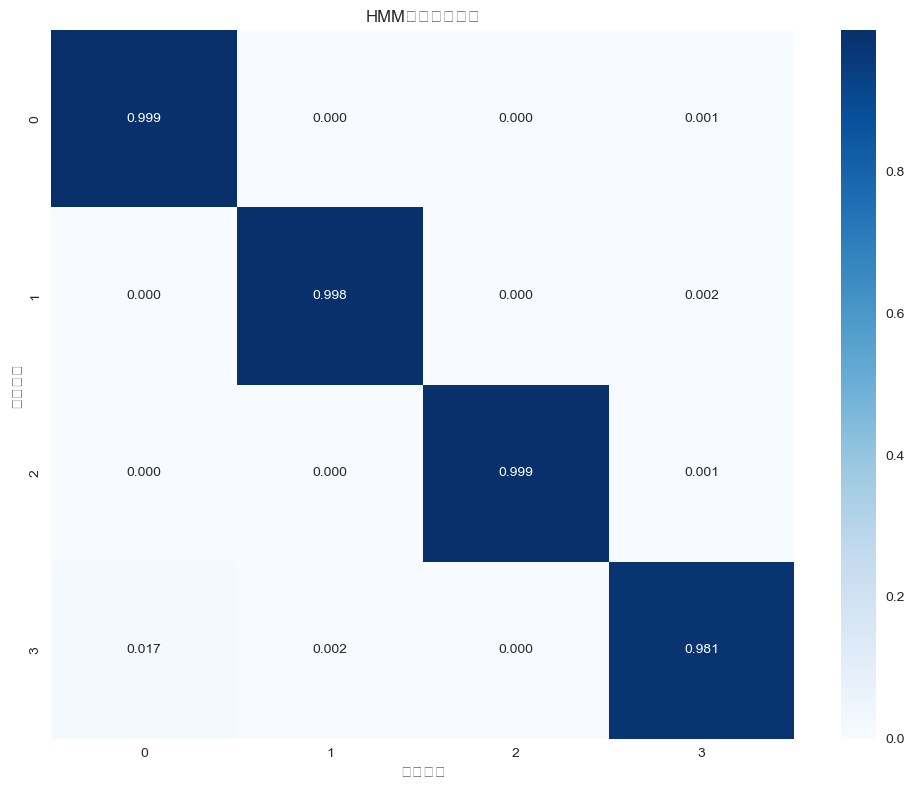


状态转移统计（训练集）:
  状态0 → 状态0: 0.999
  状态1 → 状态1: 0.998
  状态2 → 状态2: 0.999
  状态3 → 状态0: 0.017
  状态3 → 状态3: 0.981


In [9]:
# 可视化状态转移矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(coarse_hmm.transmat_, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=range(coarse_hmm.n_components),
            yticklabels=range(coarse_hmm.n_components))
plt.xlabel('下一状态')
plt.ylabel('当前状态')
plt.title('HMM状态转移矩阵')
plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / 'hmm_transition_matrix.png', dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()

# 分析状态转移（在训练集上）
print("\n状态转移统计（训练集）:")
for i in range(coarse_hmm.n_components):
    for j in range(coarse_hmm.n_components):
        if coarse_hmm.transmat_[i, j] > 0.01:  # 只显示概率>1%的转移
            print(f"  状态{i} → 状态{j}: {coarse_hmm.transmat_[i, j]:.3f}")


## 8. 保存结果


In [10]:
# 保存HMM模型
import pickle
with open(config.MODELS_DIR / 'coarse_hmm.pkl', 'wb') as f:
    pickle.dump(coarse_hmm, f)
print(f"已保存粗粒度HMM模型: {config.MODELS_DIR / 'coarse_hmm.pkl'}")

if fine_hmm is not None:
    with open(config.MODELS_DIR / 'fine_hmm.pkl', 'wb') as f:
        pickle.dump(fine_hmm, f)
    print(f"已保存细粒度HMM模型: {config.MODELS_DIR / 'fine_hmm.pkl'}")

# 保存Y标签
for name, labels in all_labels.items():
    save_intermediate(f'y_{name}', labels)
    save_intermediate(f'states_{name}', all_states[name])

# 保存HMM配置信息
hmm_info = {
    'coarse_n_states': coarse_hmm.n_components,
    'fine_n_states': fine_hmm.n_components if fine_hmm else None,
    'low_comm_state_idx': low_comm_state_idx,
    'top_k_features': top_k_features,
    'transition_matrix': coarse_hmm.transmat_.tolist(),
    'start_probabilities': coarse_hmm.startprob_.tolist(),
}
save_intermediate('hmm_info', hmm_info)

print("\n✓ 所有结果已保存")


已保存粗粒度HMM模型: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models\coarse_hmm.pkl
已保存细粒度HMM模型: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models\fine_hmm.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_train.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\states_train.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_train_val.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\states_train_val.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_val.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\states_val.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_test.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\states_test.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_

## 9. 生成HMM分析报告


In [11]:
# 生成HMM分析报告
report_path = config.REPORTS_DIR / 'hmm_analysis_report.txt'

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=== HMM建模分析报告 ===\n\n")
    
    f.write("1. 模型配置\n")
    f.write(f"   粗粒度状态数: {coarse_hmm.n_components}\n")
    f.write(f"   细粒度状态数: {fine_hmm.n_components if fine_hmm else '未训练'}\n")
    f.write(f"   低通信状态索引: {low_comm_state_idx}\n")
    f.write(f"   使用的特征数: {len(top_k_features)}\n")
    
    f.write("\n2. 训练集状态分布\n")
    train_state_dist = pd.Series(all_states['train']).value_counts().sort_index()
    for state, count in train_state_dist.items():
        f.write(f"   状态{state}: {count} 窗口 ({count/len(all_states['train'])*100:.2f}%)\n")
    
    f.write("\n3. 各数据集标签分布\n")
    for name, labels in all_labels.items():
        label_dist = pd.Series(labels).value_counts().sort_index()
        f.write(f"   {name}:\n")
        for label, count in label_dist.items():
            f.write(f"     Y={label}: {count} 窗口 ({count/len(labels)*100:.2f}%)\n")
    
    f.write("\n4. 状态转移矩阵\n")
    for i in range(coarse_hmm.n_components):
        for j in range(coarse_hmm.n_components):
            if coarse_hmm.transmat_[i, j] > 0.01:
                f.write(f"   状态{i} → 状态{j}: {coarse_hmm.transmat_[i, j]:.3f}\n")

print(f"已生成HMM分析报告: {report_path}")


已生成HMM分析报告: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports\hmm_analysis_report.txt
